<a href="https://colab.research.google.com/github/Jashanpreet645/-Learning-Probability-Density-Functions-Predictive-Assignment-4-/blob/main/_Learning_Probability_Density_Functions_Assignment_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
df = pd.read_csv("data.csv", encoding="latin1", on_bad_lines="skip")

data = df["no2"].dropna().values.reshape(-1, 1)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(data)

/tmp/ipython-input-940790490.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv", encoding="latin1", on_bad_lines="skip")


In [16]:
r = 102317065
alpha = 0.5 * (r % 7)
beta = 0.3 * ((r % 5) + 1)

z = x_scaled + alpha * np.sin(beta * x_scaled)

z = torch.tensor(z, dtype=torch.float32).to(device)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


G = Generator().to(device)
D = Discriminator().to(device)


In [17]:
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)

epochs = 5000
batch_size = 128

for epoch in range(epochs):

    idx = np.random.randint(0, z.size(0), batch_size)
    real_samples = z[idx]

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # ---- Train Discriminator ----
    noise = torch.randn(batch_size, 1).to(device)
    fake_samples = G(noise)

    loss_real = criterion(D(real_samples), real_labels)
    loss_fake = criterion(D(fake_samples.detach()), fake_labels)
    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # ---- Train Generator ----
    noise = torch.randn(batch_size, 1).to(device)
    fake_samples = G(noise)

    loss_G = criterion(D(fake_samples), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")



Epoch [1000/5000] | D Loss: 1.2947 | G Loss: 0.7205
Epoch [2000/5000] | D Loss: 1.3428 | G Loss: 0.8072
Epoch [3000/5000] | D Loss: 1.3791 | G Loss: 0.7109
Epoch [4000/5000] | D Loss: 1.3896 | G Loss: 0.6995
Epoch [5000/5000] | D Loss: 1.3860 | G Loss: 0.6916


In [18]:
G.eval()
with torch.no_grad():
    noise = torch.randn(8000, 1).to(device)
    generated_samples = G(noise).cpu().numpy()

real_samples_np = z.cpu().numpy()

wd = wasserstein_distance(real_samples_np.flatten(), generated_samples.flatten())
print("\nWasserstein Distance:", wd)


Wasserstein Distance: 0.11282573086712826


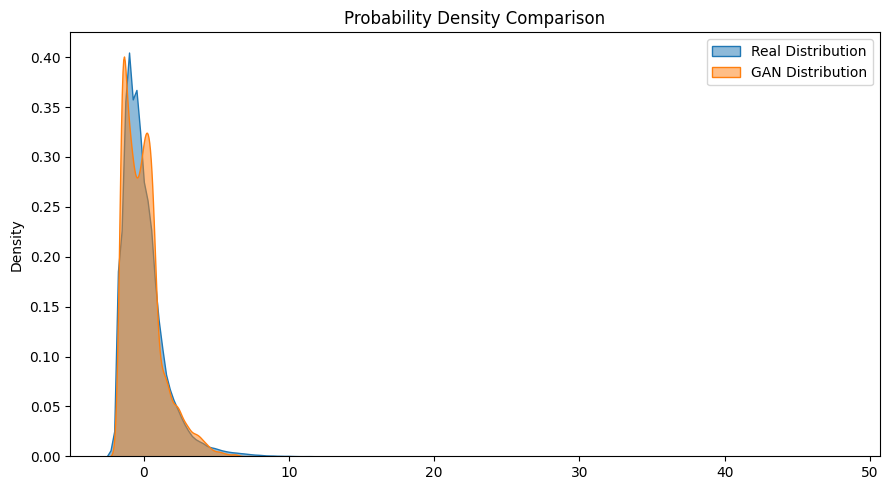

In [19]:
plt.figure(figsize=(9,5))

sns.kdeplot(real_samples_np.flatten(), fill=True, alpha=0.5, label="Real Distribution")
sns.kdeplot(generated_samples.flatten(), fill=True, alpha=0.5, label="GAN Distribution")

plt.title("Probability Density Comparison")
plt.legend()
plt.tight_layout()
plt.show()